This notebook gets the positional matches out to 10 arcseconds to Gaia sources for all pulsars in the ATNF catalogue. Once these have been acquired and saved, we determine the total number of matches as a function of search radius, from 0 to 10 arcseconds, as well as the minimum separation at which each pulsar gets a hit. Finally, we check that the total number of matches scales quadratically with search radius.

## Import relevant packages

In [18]:
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

import eliminating

In [21]:
# first step is to run get matches for 10 arcsec
filetouse = '/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/atnf_psrcat.csv'
table, hits, skipped = eliminating.get_matches(filetouse, radius= 1)

# save as npz
filename = '/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_1arcsec'
np.savez(filename, table)

## Write matches_10arcsec.csv (written into during get_matches() function call) into an astropy table

In [4]:
#initialize the tables that will end up becoming the columns of our astropy table:
psr = []
psr_ra = []
psr_dec = []
bins = []
bincomps = []
sourceid = []
ra = []
dec = []

hits = 0
psrs_hits = 0
skipped = 0

first = True

# document containing all of the pulsars in the ATNF catalogue and their matches out to 10 arcsec with relevant info
h = open('/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'r') 

# create an astropy table with all the hits from 'matches_10arcsec.csv'
for line in h:
    values = line.split(',') 

    psrname = values[0]
    psrra = values[1]
    psrdec = values[2]
    binary = values[3]
    bincomp = values[4]
    gaiasourceid = values[7]
    gaiara = values[10]
    gaiadec = values[12]

    if len(values) < 3: 
        skipped += 1 # skip pulsars without matches
    else:
        if values[0] == 'Companion Pulsar':
            psrs_hits += 1 # total number of pulsars with hits at all
            continue # skips lines that are just headers
        else:
            hits += 1
            if first:
                first = False
                psr.insert(0, psrname)
                psr_ra.insert(0, psrra)
                psr_dec.insert(0, psrdec)
                bins.insert(0, binary)
                bincomps.insert(0, bincomp)
                sourceid.insert(0, gaiasourceid)
                ra.insert(0, gaiara)
                dec.insert(0, gaiadec)
            else:
                psr.append(psrname)
                psr_ra.append(psrra)
                psr_dec.append(psrdec)
                bins.append(binary)
                bincomps.append(bincomp)
                sourceid.append(gaiasourceid)
                ra.append(gaiara)
                dec.append(gaiadec)

# instantiate the astropy table to be created
table = Table([psr, psr_ra, psr_dec, bins, bincomps, sourceid, ra, dec], names= ['Pulsar', 'Pulsar RA', 'Pulsar DEC', 'Binary', 'Bin Comp', 'Gaia Source ID','ra', 'dec'])

IndexError: list index out of range

## Save matches file as npz 

In [9]:
filename = '/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec'


np.savez(filename, Pulsar = table['Pulsar'], 
        Pulsar_RA = table['Pulsar RA'], Pulsar_DEC = table['Pulsar DEC'], Binary = table['Binary'], Bin_Comp = table['Bin Comp'],
        Gaia_Source_ID = table['Gaia Source ID'], ra = table['ra'], dec = table['dec'])

np.savez(filename, table = table)

NameError: name 'table' is not defined

## Table of source separations for each pulsar/Gaia source pair

In [15]:
# SkyCoord for each pulsar and Gaia source, respectively
psr_pos = SkyCoord(table['Pulsar RA'], table['Pulsar DEC'], frame = 'icrs', unit =(u.hourangle, u.deg))
source_pos = SkyCoord(table['ra'], table['dec'], frame = 'icrs', unit= (u.deg, u.deg))

source_seps = []
first_time = True
# table of the sky separations for each pulsar and Gaia source pair
for k in range(len(table)):
    if first_time:
        source_seps.insert(0,psr_pos[k].separation(source_pos[k]))
        first_time = False
    else:
        source_seps.append(psr_pos[k].separation(source_pos[k]))

## List all pulsars with hits

In [16]:
# here we are creating a list of the names of the pulsars that had hits, without reduplication
current = 'J0024-7204aa'
psrs_with_hits = [current]
decs = [psr_pos[0].dec] # declination of the first pulsar in the table
ras = [psr_pos[0].ra] # ra of the first pulsar in the table
a = 0
for b in table['Pulsar']:
    if b != current:
        psrs_with_hits.append(b)
        decs.append(psr_pos[a].dec)
        ras.append(psr_pos[a].ra)
        current = b
    a += 1
n_psrs_with_hits = len(psrs_with_hits) # total number of PULSARS with hits, distinct from total number of hits

## Find minimum separation to a Gaia source for each pulsar that had any hits

In [17]:
# minimum distance to 1 hit for every pulsar with any hits
mins = np.zeros(len(psrs_with_hits))
min_ids = np.zeros(len(psrs_with_hits))
for d in range(len(psrs_with_hits)):
    first_time = True
    for c in range(len(table['Pulsar'])):
        # for each pulsar, go through all the associated Gaia sources, and find the one with min sep
        if table['Pulsar'][c] == psrs_with_hits[d]:
            if first_time:
                first_time = False
                minimum = source_seps[c].to_value(u.arcsec)
                min_id = table['Gaia Source ID'][c]
            else:
                if source_seps[c].to_value(u.arcsec) < minimum:
                    minimum = source_seps[c].to_value(u.arcsec)
                    min_id = table['Gaia Source ID'][c]
    mins[d] = minimum
    min_ids[d] = min_id

## Table of pulsar and minimal seps
The next couple code blocks create various pulsar/min sep tables based on certain restrictions such as distance from galactic plane, inner or outer galaxy, etc. -- would be more efficient to simply have one table that holds all of this info for each pulsar, and restrict things that way

In [18]:
# create an astropy table that contains each unique pulsar with a hit, and the minimal distance to a Gaia source for each psr
min_dist = Table([psrs_with_hits, mins, decs, ras, min_ids], names= ['Pulsars with Hits', 'Distance to at least 1 hit', 'Declinations',
                                                             'Right Ascensions', 'Gaia Source ID'])

# create restricted tables of just pulsars within 5 deg and 10 deg declination of the galactic plane:
restrictions = [5, 10]
rest_psrs_with_hits = []
rest_mins = []
rest_decs = []
rest_ras = []
first_time = True
for a in range(len(restrictions)):
    for i in range(len(min_dist['Pulsars with Hits'])):
        if min_dist['Declinations'][i] > -28.94 - restrictions[a] and min_dist['Declinations'][i] < -28.94 + restrictions[a]:
            if first_time:
                rest_psrs_with_hits.insert(0, min_dist['Pulsars with Hits'][i])
                rest_mins.insert(0, min_dist['Distance to at least 1 hit'][i])
                rest_decs.insert(0, min_dist['Declinations'][i])
                rest_ras.insert(0, min_dist['Right Ascensions'][i])
                first_time = False
            else:
                rest_psrs_with_hits.append(min_dist['Pulsars with Hits'][i])
                rest_mins.append(min_dist['Distance to at least 1 hit'][i])
                rest_decs.append(min_dist['Declinations'][i]) 
                rest_ras.append(min_dist['Right Ascensions'][i])
    if a == 0:
        rest_min_dist5 = Table([rest_psrs_with_hits, rest_mins, rest_decs, rest_ras], names= ['Pulsars with Hits', 'Distance to at least 1 hit', 'Declinations', 'Right Ascensions'])
    else:
        rest_min_dist10 = Table([rest_psrs_with_hits, rest_mins, rest_decs, rest_ras], names= ['Pulsars with Hits', 'Distance to at least 1 hit', 'Declinations', 'Right Ascensions'])

In [12]:
# now, looking at abs(b) < 5, look at both inner galaxy and outer galaxy
# in galactic coordinates, do l = -90 to 90 deg for inner galaxy (galactic center is l = 0 degrees)
# in ra, l = 0 corresponds to ra = 17h45.6m

ub = SkyCoord(l=90, b=0, frame='galactic', unit= u.deg)
lb = SkyCoord(l=-90, b=0, frame='galactic', unit= u.deg)
gal_center = SkyCoord(l=0,b=0, frame='galactic', unit= u.deg)

# inner galaxy
# take the pulsars in rest_min_dist5, the table with all the pulsars with hits within 5 deg of the galactic plane, and restrict to those between lr and ur
upper_rest = ub.icrs.ra
lower_rest = lb.icrs.ra
inner_gal = rest_min_dist5[:0].copy()
for i in range(len(rest_min_dist5)):
    if rest_min_dist5['Right Ascensions'][i] < upper_rest.value and rest_min_dist5['Right Ascensions'][i] > lower_rest.value:
        inner_gal.add_row(rest_min_dist5[i])
np.savez('/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec_innergal', table = inner_gal)

# outer galaxy
# take the pulsars in rest_min_dist5, the table with all the pulsars with hits within 5 deg of the galactic plane, and restrict to those between lr and ur on the other side
outer_gal = rest_min_dist5[:0].copy()
for j in range(len(rest_min_dist5)):
    if rest_min_dist5['Right Ascensions'][j] > upper_rest.value or rest_min_dist5['Right Ascensions'][j] < lower_rest.value:
        outer_gal.add_row(rest_min_dist5[j])
np.savez('/home/billee/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec_outergal', table = outer_gal)

Pulsars with Hits,Distance to at least 1 hit,Declinations,Right Ascensions
str12,float64,float64,float64
J0720-3125,6.36542510820825,-31.430578611111113,110.10400833333331
J0737-3039A,1.6241393800481896,-30.661309530555553,114.46353507916666
J0737-3039B,1.6241393800481896,-30.661309530555553,114.46353507916666
J0742-2822,9.56848396732046,-28.378822222222222,115.70440833333332


## For each case (inner gal, outer gal, etc.) instantiate array of number of position matches as a function of search radius, normalized by the number of pulsars 
From this we can plot the fraction of all pulsars that get a gaia hit by search radius

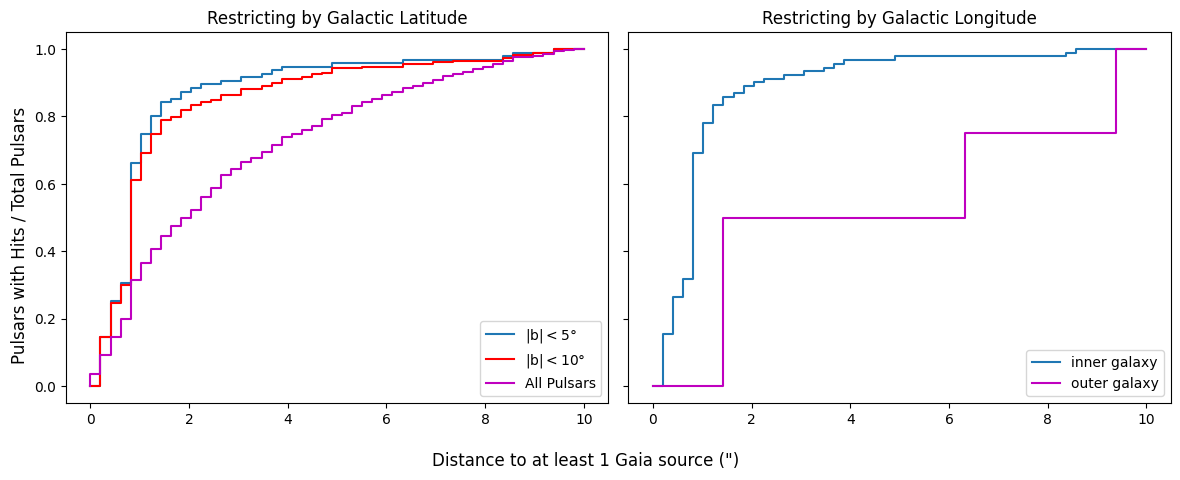

In [29]:
dist_to_one_psr = np.linspace(0,10,50) # x-axis: possible psr-Gaia separations

n_psr_norm5 = np.zeros(len(dist_to_one_psr)) # table that will hold the y-values corresponding to each x-value
# for loop that iterates through each possible Gaia-psr separation and counts how many pulsars have a minimum separation less than or equal to that value
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(rest_min_dist5['Distance to at least 1 hit'])):
        if rest_min_dist5['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm5[e] = num/len(rest_min_dist5['Pulsars with Hits']) # number of psrs with at least one Gaia source normalized by total number of pulsars with hits
n_psr_norm5

n_psr_norm10 = np.zeros(len(dist_to_one_psr)) # table that will hold the y-values corresponding to each x-value
# for loop that iterates through each possible Gaia-psr separation and counts how many pulsars have a minimum separation less than or equal to that value
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(rest_min_dist10['Distance to at least 1 hit'])):
        if rest_min_dist10['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm10[e] = num/len(rest_min_dist10['Pulsars with Hits']) # number of psrs with at least one Gaia source normalized but total number of pulsars with hits
n_psr_norm10

n_psr_norm = np.zeros(len(dist_to_one_psr)) # table that will hold the y-values corresponding to each x-value
# for loop that iterates through each possible Gaia-psr separation and counts how many pulsars have a minimum separation less than or equal to that value
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(min_dist['Distance to at least 1 hit'])):
        if min_dist['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm[e] = num/len(min_dist['Pulsars with Hits']) # number of psrs with at least one Gaia source normalized but total number of pulsars with hits
n_psr_norm

n_psr_norm_inner = np.zeros(len(dist_to_one_psr)) # table that will hold the y-values corresponding to each x-value
# for loop that iterates through each possible Gaia-psr separation and counts how many pulsars have a minimum separation less than or equal to that value
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(inner_gal['Distance to at least 1 hit'])):
        if inner_gal['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm_inner[e] = num/len(inner_gal['Pulsars with Hits']) # number of psrs with at least one Gaia source normalized but total number of pulsars with hits

n_psr_norm_outer = np.zeros(len(dist_to_one_psr)) # table that will hold the y-values corresponding to each x-value
# for loop that iterates through each possible Gaia-psr separation and counts how many pulsars have a minimum separation less than or equal to that value
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(outer_gal['Distance to at least 1 hit'])):
        if outer_gal['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm_outer[e] = num/len(outer_gal['Pulsars with Hits']) # number of psrs with at least one Gaia source normalized but total number of pulsars with hits

# plot values
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize= (12.0, 4.8))
ax1.step(dist_to_one_psr, n_psr_norm5, label= r'|b|$ < 5 \degree$')
ax1.step(dist_to_one_psr, n_psr_norm10, label= r'|b|$ < 10 \degree$', color= 'r')
ax1.step(dist_to_one_psr, n_psr_norm, label= 'All Pulsars', color= 'm')
# ax1.set_xlabel('Distance to at least 1 Gaia source (")')
# ax1.set_ylabel('Pulsars with Hits / Total Pulsars')
ax1.set_title('Restricting by Galactic Latitude')
ax1.legend()

ax2.step(dist_to_one_psr, n_psr_norm_inner, label= 'inner galaxy')
ax2.step(dist_to_one_psr, n_psr_norm_outer, label= 'outer galaxy', color= 'm')
# ax2.set_xlabel('Distance to at least 1 Gaia source (")')
# ax2.set_ylabel('Pulsars with Hits / Total Pulsars')
ax2.set_title('Restricting by Galactic Longitude')
ax2.legend()

#fig.suptitle('Fraction of all Pulsars with Hits to 10 "')
fig.supylabel('Pulsars with Hits / Total Pulsars')
fig.supxlabel('Distance to at least 1 Gaia source (")')
fig.tight_layout()

## Instantiate arrays of the number of hits as a function of search radius for full range, as well as for only lower search radii

In [19]:
seps1 = np.linspace(0,10,200)
seps2 = np.linspace(0, 4, 25)

numhits1 = np.zeros(len(seps1)) 
for i in range(len(seps1)):
    num = 0
    for j in range(len(source_seps)):
        if source_seps[j].arcsec <= seps1[i]:
            num += 1
    numhits1[i] = num

numhits2 = np.zeros(len(seps2)) 
for i in range(len(seps2)):
    num = 0
    for j in range(len(source_seps)):
        if source_seps[j].arcsec <= seps2[i]:
            num += 1
    numhits2[i] = num

## Fit a quadratic to these relations, and plot data along with fits

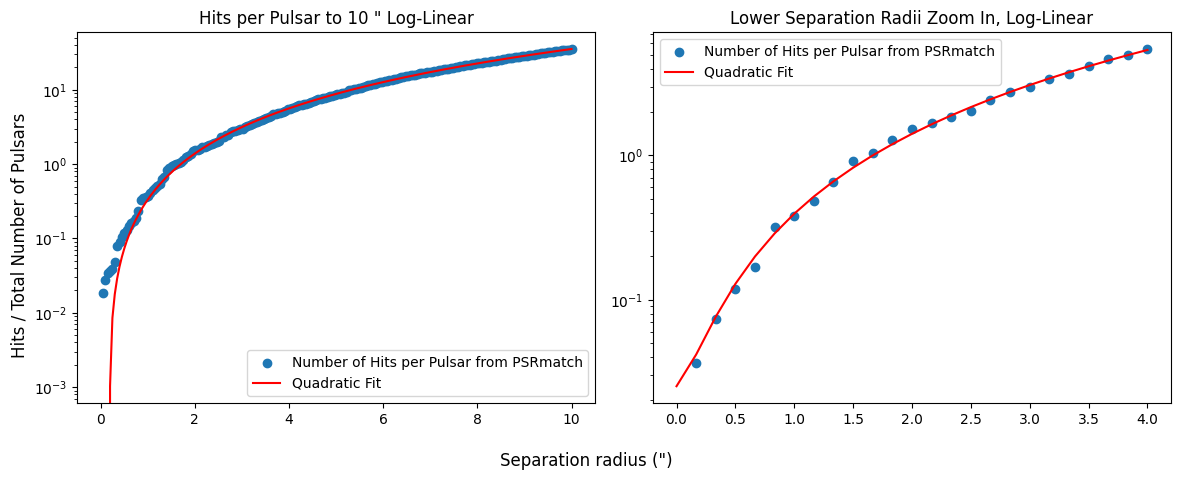

In [30]:
hits_per_pulsar1 = numhits1/(psrs_hits)
hits_per_pulsar2 = numhits2/(psrs_hits)
a1, b1, c1 = np.polyfit(seps1, hits_per_pulsar1, 2)
a2, b2, c2 = np.polyfit(seps2, hits_per_pulsar2, 2)

# google how to get chisquared 

def quadratic1(a,b,c):
    return a* (seps1**2) + b*(seps1) + c

def quadratic2(a,b,c):
    return a* (seps2**2) + b*(seps2) + c

fig = plt.figure(figsize=(12.0, 4.8))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
# ax3 = plt.subplot(121)
# ax4 = plt.subplot(122)
# ax5 = plt.subplot(121)
# ax6 = plt.subplot(122)

# log linear
ax1.set_yscale('log')
ax1.scatter(seps1, hits_per_pulsar1, label= 'Number of Hits per Pulsar from PSRmatch')
ax1.plot(seps1, quadratic1(a1,b1,c1), label= 'Quadratic Fit', c= 'r')
# ax1.set_xlabel('Separation radius (")')
# ax1.set_ylabel('Hits / 437')
ax1.set_title('Hits per Pulsar to 10 " Log-Linear')
ax1.legend()

ax2.set_yscale('log')
ax2.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
ax2.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
# ax2.set_xlabel('Separation radius (")')
# ax2.set_ylabel('Hits / 437')
ax2.set_title('Lower Separation Radii Zoom In, Log-Linear')
ax2.legend()

# #linear 
# ax3.scatter(seps1, hits_per_pulsar1, label= 'Number of Hits per Pulsar from PSRmatch')
# ax3.plot(seps1, quadratic1(a1,b1,c1), label= 'Quadratic Fit', c= 'r')
# ax3.set_xlabel('Separation radius (")')
# ax3.set_ylabel('Hits / 437')
# ax3.set_title('Hits per Pulsar to 10 " Linear')
# ax3.legend()

# ax4.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
# ax4.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
# ax4.set_xlabel('Separation radius (")')
# ax4.set_ylabel('Hits / 437')
# ax4.set_title('Lower Separation Radii Zoom In, Linear')
# ax4.legend()

# #log-log
# ax5.set_xscale('log')
# ax5.set_yscale('log')
# ax5.scatter(seps1, hits_per_pulsar1, label= 'Number of Hits per Pulsar from PSRmatch')
# ax5.plot(seps1, quadratic1(a1,b1,c1), label= 'Quadratic Fit', c= 'r')
# ax5.set_xlabel('Separation radius (")')
# ax5.set_ylabel('Hits / 437')
# ax5.set_title('Hits per Pulsar to 10 " Log-Log')
# ax5.legend()

# ax6.set_xscale('log')
# ax6.set_yscale('log')
# ax6.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
# ax6.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
# ax6.set_xlabel('Separation radius (")')
# ax6.set_ylabel('Hits / 437')
# ax6.set_title('Lower Separation Radii Zoom In, Log-Log')
# ax6.legend()

#fig.suptitle('Hits per Pulsar')
fig.supylabel('Hits / Total Number of Pulsars')
fig.supxlabel('Separation radius (")')
fig.tight_layout()

In [25]:
dist_to_one_psr = np.linspace(0,1,30)
n_psr = np.zeros(len(dist_to_one_psr))
for i in range(len(dist_to_one_psr)):
    first_one = True
    psrs = []
    for j in range(len(source_seps)):
        if source_seps[j].value < dist_to_one_psr[i]:
            if first_one:
                psrs.insert(0,table['Pulsar'][j])
                first_one = False
            else:
                add = True
                for k in range(len(psrs)):
                    if table['Pulsar'][j] == psrs[k]:
                        add = False
                if add:
                    psrs.append(table['Pulsar'][j])
    n_psr[i] = len(psrs)
n_psr

array([  0., 437., 437., 437., 437., 437., 437., 437., 437., 437., 437.,
       437., 437., 437., 437., 437., 437., 437., 437., 437., 437., 437.,
       437., 437., 437., 437., 437., 437., 437., 437.])

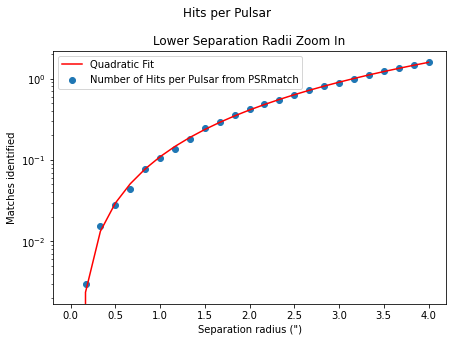

In [5]:
zoomed_hits_per_psr = np.array([   0.,   10.,   51.,   94.,  149.,  257.,  349.,  460.,  606.,
        823.,  986., 1198., 1409., 1618., 1830., 2110., 2432., 2714.,
       2969., 3273., 3646., 4080., 4497., 4833., 5314.])

seps2 = np.linspace(0, 4, 25)

hits_per_pulsar2 = zoomed_hits_per_psr/(3342)
a2, b2, c2 = np.polyfit(seps2, hits_per_pulsar2, 2)

# google how to get chisquared 

def quadratic1(a,b,c):
    return a* (seps1**2) + b*(seps1) + c

def quadratic2(a,b,c):
    return a* (seps2**2) + b*(seps2) + c

fig = plt.figure(figsize=(6.4, 4.8))
ax2 = plt.subplot()

ax2.set_yscale('log')
ax2.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
ax2.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
ax2.set_xlabel('Separation radius (")')
ax2.set_ylabel('Matches identified')
ax2.set_title('Lower Separation Radii Zoom In')
ax2.legend()

fig.suptitle('Hits per Pulsar')
fig.tight_layout()